# DKRZ Python visualization


## IMS daily Northern Hemisphere snow and ice analysis data

----

```
Copyright 2022 Deutsches Klimarechenzentrum GmbH (DKRZ)
Licensed under CC-BY-NC-SA-4.0
```

----

The **IMS (Interactive Multisensor Snow and Ice Mapping System)** data from the **NIC (National Ice Center)** are available in different formats whereas the lat/lon grid data are only available in separate binary files.

This example describes how to download the data and grid files for the `24km` resolution. We use the ASCII data and want to create a plot of the `snow & ice chart` values on a north polar map. 

The data are mapped to the north polar stereographic projection with a center longitude of 90°E and a center latitude of 90°N, which differ from the User Guide, but gives us the correct plotting result. Another problem are the NaNs in the data and the lat/lon arrays, therefore we have to create a mask for the data array before we can use Matplotlib/Cartopy for plotting.

**Content**
- Read the ASCII data
- Read the lat/lon binary data
- Create masked xr.DataArray
- Plotting

**Projection:** 

    projection = ccrs.NorthPolarStereo(central_longitude=90.)
    transform  = ccrs.Stereographic(central_longitude=90., central_latitude=90.)

    Used proj settings:
        Proj4: +proj=stere +lat_0=90 +lon_0=90 +k=1 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs +type=crs
    
    The proj4 setting from IMS User Guide doesn't fit!
        Proj4: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-80 +k=1 +x_0=0 +y_0=0 +a=6378137 +b=6356257 +units=m +no_defs
                                                       
----

**IMS**

https://nsidc.org/data/g02156/versions/1#anchor-1 <br>
https://nsidc.org/sites/default/files/g02156-v001-userguide_1_1.pdf

**List ftp directory content**

The output will be written to the local file `.listing`.

    wget --no-remove-listing --spider --ftp-user=anonymous ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02156/24km/2022/
    
    more .listing
    drwxrwxr-x    2 500    510    18615 Dec 31 07:10 .
    drwxr-xr-x   29 500    510      594 Jan  1 07:10 ..
    -rw-rw-r--    1 500    510    26703 Apr 18  2022 ims2022001_00UTC_24km_v1.3.asc.gz
    -rw-rw-r--    1 500    510    26415 Apr 18  2022 ims2022002_00UTC_24km_v1.3.asc.gz
    ...

**Download directory content**

    wget --ftp-user=anonymous -r -nd ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G02156/24km/2022/

----

**IMS Data citation:**

U.S. National Ice Center. (2008). IMS Daily Northern Hemisphere Snow and Ice Analysis at 1 km, 4 km, and 24 km Resolutions, Version 1 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/N52R3PMC. Date Accessed 02-21-2023.

<br>


### Import packages

In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as colorbar
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### Download data

To download the data change the cell type for the following cell to `code`.


### Data header


Header: 30-rows

    Julian day of IMS data log: 2022364
    Processing day            : Fri Dec 30 22:02:31 2022
    Total # scientific data sets: 1
    File description:
    This file contains Northern Hemisphere snow and ice coverage analyzed in the Interactive Multisensor Snow and Ice Mapping System (IMS) from blended satellite and other data inputs. It is produced under direction from the NOAA National Weather Service's Ocean Prediction Center and the U.S. National Ice Center. For more information, please email nic.ims.analysts@noaa.gov.
    Map Label: Northern Hemisphere 1024x1024 snow and ice coverage
    Coordinate System: Polar Stereographic
    Data Values: 1 (open water), 2 (land without snow), 3 (sea or lake ice), 4 (snow covered land), 0 (outside Northern Hemisphere).
    Format: I1
    Dimensions: 1024 x 1024
    (1,1) starts at: lower left corner
    ------------- Data set starts here: --------
       
     Data Set #       1
       Data Label:
    Northern Hemisphere 1024x1024 Snow & Ice Chart
       Coordinate System:                   Polar Stereographic
       Data Type:                           BYTE
       Format:                              I1
       Dimensions:                            1024        1024
       Min/Max Values:                         0 4
       Units:                               8-bit Flag
       Dimension #       0
         Dim Label:                         Longitude
         Dim Format:                        Device Coordinates
         Dim Units:                         Pixels
       Dimension #       1
         Dim Label:                         Latitude
         Dim Format:                        Device Coordinates
         Dim Units:                         Pixels
    


### Grid size

Size of dimension nx == ny.

In [2]:
nx = ny = 1024

### Read ASCII file

Read the IMS ASCII data which has 30 lines of header and the integer values aren't separated.

In [4]:
with open('../../data/ims2022365_00UTC_24km_v1.3.asc') as f:
    f.seek(0)
    w = np.full((1024), 1, dtype=int)
    data = pd.read_fwf(f, widths=w, lineterminator='\n', header=None, skiprows=30).values

### Data description

|Value |Description|
|----|-----------|
|0 |Outside the coverage area|
|1 |Sea|
|2 |Land (without snow)|
|3, 164 |Sea Ice<br>Note: The value 164 only pertains to the 24 km ASCII files listed in the Note on Packed Versus Unpacked Format below.|
|4, 165 |Snow covered land<br>Note: The value 165 only pertains to the 24 km ASCII files listed in the Note on Packed Versus Unpacked Format below.|

Define the labels for the colorbar of the plot.

In [5]:
labels = ['0 - Outside', '1 - Sea', '2 - Land', '3 - Sea Ice', '4 - Snow covered \nland']

### Read lat/lon binary data

The latitude and longitude data that are stored in separate binary files.

Read **latitude** data:

In [7]:
with open('../../data/imslat_24km.bin', 'rb') as f:
    f.seek(0)
    d = np.fromfile(f, dtype=np.float32, count=nx * ny)
    lats = np.reshape(d, [nx, ny], order='F')

Read **longitude** data:

In [9]:
with open('../../data/imslon_24km.bin', 'rb') as f:
    f.seek(0)
    d = np.fromfile(f, dtype=np.float32, count=nx * ny)
    lons = np.reshape(d, [nx, ny], order='F')

### Create masked xr.DataArray

Now we have all we need to create an Xarray DataArray of the data. It allows us to add the coordinate arrays and some attributes to the data.

In [10]:
da_data = xr.DataArray(data=data,
                       dims=['y', 'x'],
                       coords=dict(lon=(['y', 'x'], lons),
                                   lat=(['y', 'x'], lats)),
                       attrs=dict(standard_name="snow_ice_chart",
                                  units="Snow & Ice Chart",
                                  _FillValue = np.nan),
                       )

Data Values: 

1 (open water), 2 (land without snow), 3 (sea or lake ice), 4 (snow covered land), 0 (outside Northern Hemisphere)

In [11]:
proj = ccrs.NorthPolarStereo()
coords = proj.transform_points(ccrs.PlateCarree(), lons, lats)

The data as well as the coordinate arrays contain NaNs which is a problem when we want to create the plot. Therefore we need to mask the NaNs with Numpy's np.ma.masked_invalid() method and pass it to the np.logical_or() method to attach the resulting mask array to the data.

In [12]:
x = np.ma.masked_invalid(coords[..., 0])
y = np.ma.masked_invalid(coords[..., 1])
data = np.ma.masked_invalid(da_data)

data.mask = np.logical_or(data.mask, x.mask, y.mask)

Matplotlib's contourf method can't handle masked arrays. But here it doesn't matter, as the data is now masked at these locations.

In [13]:
x = x.filled(0)
y = y.filled(0)

### Plotting 

Settings for the colors, use only grays or blue, green, yellow, white.

In [14]:
use_grays = True

if use_grays:
    colors = ['dimgray', 'darkgray', 'lightgray', 'white']
    lc = 'black'
else:
    colors = ['navy', 'darkgreen', 'yellow', 'white']
    lc = 'gray'
    
num_colors = len(colors)
cmap = mcolors.ListedColormap(colors)
levels = range(num_colors+1)
vmin = 1
vmax = 4

Notice, that we don't use the same projection and transformation settings as written in the IMS User Guide. If we would use the values from the IMS User Guide the data won't fit with the coastlines. The central longitude and latitude have to be set to 90., the setting of true_scale_latitude=60. (see User Guide) shows no effect here.

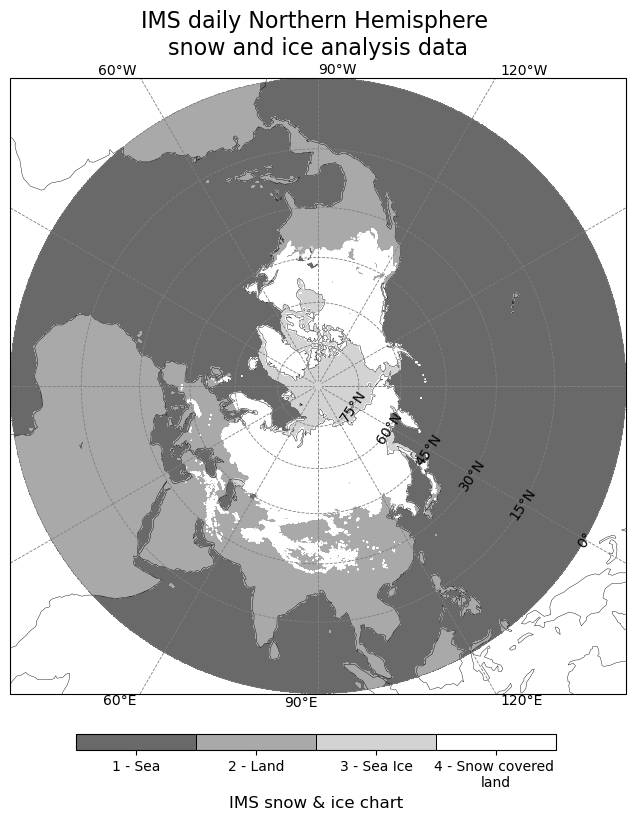

In [15]:
proj = ccrs.NorthPolarStereo(central_longitude=90.)  #  true_scale_latitude=60. shows no effect
trans = ccrs.Stereographic(central_longitude=90., central_latitude=90.)  # true_scale_latitude=60. shows no effect

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': proj})

ax.set_title('IMS daily Northern Hemisphere \nsnow and ice analysis data',
            fontsize=16)
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), lw=0.3, ec='black')

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), 
                  color='gray', ls='--', lw=0.6)
xticks = np.arange(-180, 181, 30)
yticks = np.arange(0, 91, 15)
gl.ylocator = mticker.FixedLocator(yticks)
gl.xlocator = mticker.FixedLocator(xticks)
gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation':0}
gl.ylabel_style = {'size': 10, 'color': lc, 'rotation':56}

plot = ax.contourf(x, y, data, levels=levels, cmap=cmap, transform=trans)

cax = fig.add_axes([0.21, 0.04, 0.6, 0.02], autoscalex_on=True) #-- x,y,w,h
cbar = colorbar.Colorbar(cax,
                         orientation='horizontal',
                         cmap=cmap,
                         norm=plt.Normalize(-0.5, len(colors) - 0.5))
cbar.set_ticks(range(len(colors)))
cbar.ax.set_xticklabels(labels[1:], fontsize=10)
cbar.solids.set_edgecolor('black')
cbar.solids.set_linewidth(0.5)
cbar.set_label(label='IMS snow & ice chart', fontsize=12)

plt.savefig('./plots/plot_IMS_daily_NH_snow_ice_chart.png', bbox_inches='tight', facecolor='white')

### Plotting - a somewhat prettier representation

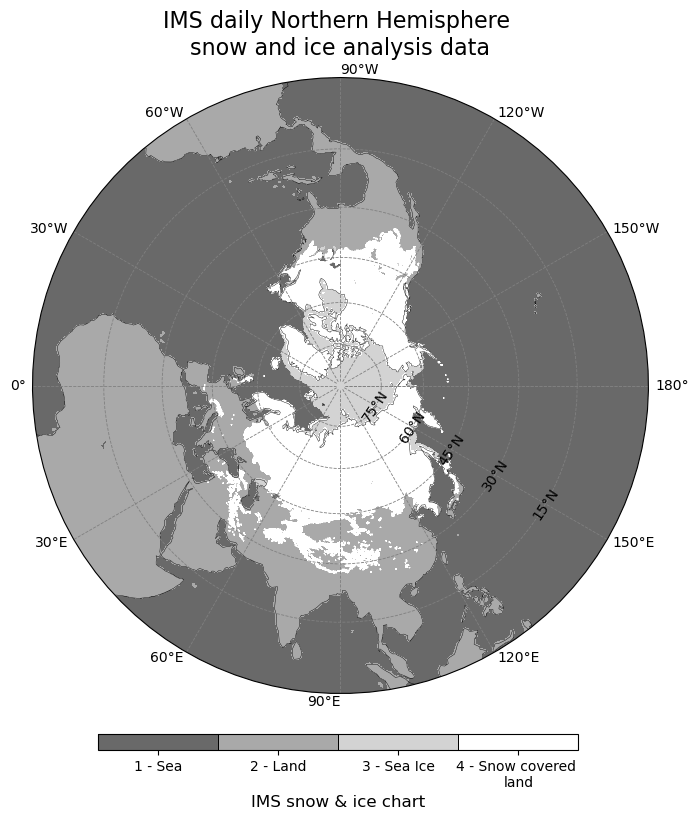

In [16]:
proj = ccrs.NorthPolarStereo(central_longitude=90.)  #  true_scale_latitude=60. shows no effect
trans = ccrs.Stereographic(central_longitude=90., central_latitude=90.)  # true_scale_latitude=60. shows no effect

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'projection': proj})

ax.set_title('IMS daily Northern Hemisphere \nsnow and ice analysis data',
            fontsize=16)
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), lw=0.3, ec='black')

gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), 
                  color='gray', ls='--', lw=0.6)
xticks = np.arange(-180, 181, 30)
yticks = np.arange(0, 91, 15)
gl.ylocator = mticker.FixedLocator(yticks)
gl.xlocator = mticker.FixedLocator(xticks)
gl.xlabel_style = {'size': 10, 'color': 'black', 'rotation':0}
gl.ylabel_style = {'size': 10, 'color': lc, 'rotation':56}

plot = ax.contourf(x, y, data, levels=levels, cmap=cmap, transform=trans)

cax = fig.add_axes([0.21, 0.04, 0.6, 0.02], autoscalex_on=True) #-- x,y,w,h
cbar = colorbar.Colorbar(cax,
                         orientation='horizontal',
                         cmap=cmap,
                         norm=plt.Normalize(-0.5, len(colors) - 0.5))
cbar.set_ticks(range(len(colors)))
cbar.ax.set_xticklabels(labels[1:], fontsize=10)
cbar.solids.set_edgecolor('black')
cbar.solids.set_linewidth(0.5)
cbar.set_label(label='IMS snow & ice chart', fontsize=12)

# Circular boundary of the map
# (see https://scitools.org.uk/cartopy/docs/v0.15/examples/always_circular_stereo.html)

import matplotlib.path as mpath

theta  = np.linspace(0, 2*np.pi, 100)
center = [0.5, 0.5]
radius =  0.5
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

plt.savefig('./plots/plot_IMS_daily_NH_snow_ice_chart.png', bbox_inches='tight', facecolor='white')